In [1]:
import matplotlib.pyplot as plt
%matplotlib widget

import numpy as np
from scipy.signal import peak_widths
import h5py
import collections
import colorsys

from utils.decompose_dict_and_h5_groups import decompose_h5_groups_to_dict
# from wideflow.analysis.utils.plot_box_plot import plot_box_plot


In [2]:
# plot box plot
def plot_box_plot(ax, *args, **kwargs):
    '''

    Args:
        ax: pyplot figure axis for ploting
        *args: numpy 2d arrays - columns corresponds to data for specific x-values. Each arg will add box plot to all
                                 x-values
        **kwargs: pyplot key-value pairs - axis attributes

    Returns:

    '''
    nargs = len(args)
    hsv_tuples = [(x * 1.0 / nargs, 0.5, 0.5) for x in range(nargs)]
    nx = args[0].shape[1]  # nx should be the same for each arg
    x = np.arange(nx)
    width = (1 / nargs) / 2

    bp = []
    # plot box plots
    for i, data in enumerate(args):
        if data.shape[0] == 1:
            notch = True
        else:
            notch = False
        bp.append([None] * nx)
        for j in range(nx):
            bp[i][j] = ax.boxplot(data[:, j], widths=width, positions=[x[j] + i * width], notch=notch, patch_artist=True,
                        boxprops=dict(facecolor=hsv_tuples[i]), medianprops=dict(color="black"))

    # plot trend lines
    bp_med = []
    for i in range(nargs):
        bp_med.append([None] * nx)
        for j in range(nx):
            bp_med[i][j] = bp[i][j]['medians'][0].get_ydata()[0]

    bp_med = np.array(bp_med)
    for i in range(nargs):
        ax.plot(x + i * width, bp_med[i, :], color=hsv_tuples[i], linestyle='--')
        ax.set_xticks(x + width)

    # add axis methods
    for key, val in kwargs.items():
        attr = getattr(ax, key)
        attr(val)


        
# paint cortex map ROIs
def paint_roi(rois_dict, cortex_map, rois_names, rois_vals=None, ax=None):
    if rois_vals is None:
        rois_vals = {}
        for roi_name in rois_names:
            rois_vals[roi_name] = 1

    elif len(rois_names) != len(rois_vals):
        raise Exception('The number of elements in rois_names and rois_vals should be the same')

    paint_map = np.zeros((cortex_map.shape))
    paint_map[:] = cortex_map[:]
    for roi_name in rois_names:
        roi_pixels_list = rois_dict[roi_name]["PixelIdxList"]
        pixels_inds = np.unravel_index(roi_pixels_list, (cortex_map.shape[1], cortex_map.shape[0]))
        paint_map[pixels_inds[1], pixels_inds[0]] = rois_vals[roi_name]
    if ax is None:
        plt.figure()
        plt.imshow(paint_map)
    else:
        return ax.imshow(paint_map)

def load_extended_rois_list(file_path):
    with h5py.File(file_path, 'r') as f:
        roi_list = {}
        for key, grp in f.items():
            roi_list[key] = {}
            roi_list[key]['Index'] = int(key.split('_')[1])
            roi_list[key]['Area'] = grp['Area'][()]
            roi_list[key]['Centroid'] = grp['Centroid'][()]
            roi_list[key]['PixelIdxList'] = grp['PixelIdxList'][()] - 1  # -1 to convert from matlab to python
            roi_list[key]['outline'] = grp['outline'][()]
            roi_list[key]['top_left_bottom_rigth'] = grp['top_left_bottom_rigth'][()]
            roi_list[key]['name'] = grp['name'][()]
    
    roi_list = {k: v for k, v in sorted(roi_list.items(), key=lambda item: item[1]['Index'])}
    return roi_list


In [3]:
# data paths
base_path = '/data/Rotem/WideFlow prj/'
statistics_path = base_path + 'results/sessions_statistics.h5'
dataset_path = base_path + 'results/sessions_dataset.h5'
rois_dict_path = '/data/Rotem/Wide Field/WideFlow/data/cortex_map/allen_2d_cortex_rois_extended.h5'
cortex_map_path = '/data/Rotem/Wide Field/WideFlow/data/cortex_map/allen_2d_cortex.h5'


In [4]:
# mouse ID and sessions to examine - CHANGE IT IF NECESSARY
mouse_id = '2680'
mouse_base_path = base_path + mouse_id + '/'

sessions_names = [
    '20211125_neurofeedback',
    '20211130_neurofeedback',
    '20211206_neurofeedback',
    '20211208_neurofeedback'
]


In [5]:
# load data
with h5py.File(cortex_map_path, 'r') as f:
    cortex_mask = np.transpose(f["mask"][()])
    cortex_map = np.transpose(f["map"][()])

rois_dict = load_extended_rois_list(rois_dict_path)
rois_dict = collections.OrderedDict(sorted(rois_dict.items()))
rois_names_code = list(rois_dict.keys())
rois_names = [v['name'] for k, v in rois_dict.items()]

nrois = len(rois_dict)
metric_rois_idx = [8]
metric_bool_arr = np.array([True if i in metric_rois_idx else False for i in range(nrois)])
non_metric_bool_arr = np.invert(metric_bool_arr)

sessions_stats = {}
with h5py.File(statistics_path, 'a') as f:
    decompose_h5_groups_to_dict(f, sessions_stats, f'/{mouse_id}/')


In [ ]:
# prepare data for ploting
plot_data = {}
for sess_name in sessions_names:
    sess_data = sessions_stats[sess_name]

    dff_pstr = sess_data['traces']['pstr_sim_rewards']
    dff_zscore_pstr = sess_data['traces']['zscore_pstr_sim_rewards']

    div_pstr = sess_data['regression_divergence']['pstr_sim_rewards']
    div_zscore_pstr = sess_data['regression_divergence']['zscore_pstr_sim_rewards']

    diff_1f_pstr = sess_data['delta_frames_diff']['delta_frames_1']['pstr_sim_rewards']
    diff_1f_zscore_pstr = sess_data['delta_frames_diff']['delta_frames_1']['zscore_pstr_sim_rewards']

    diff_3f_pstr = sess_data['delta_frames_diff']['delta_frames_3']['pstr_sim_rewards']
    diff_3f_zscore_pstr = sess_data['delta_frames_diff']['delta_frames_3']['zscore_pstr_sim_rewards']

    diff_5f_pstr = sess_data['delta_frames_diff']['delta_frames_5']['pstr_sim_rewards']
    diff_5f_zscore_pstr = sess_data['delta_frames_diff']['delta_frames_5']['zscore_pstr_sim_rewards']
    
    sess_plot_data = {}
    # pstr (simulated rewards) - peaks
    sess_plot_data["dff_pstr_max"] = np.max(dff_pstr, axis=1)
    sess_plot_data["dff_zscore_pstr_max"] = np.max(dff_zscore_pstr, axis=1)

    sess_plot_data["div_pstr_max"] = np.max(div_pstr, axis=1)
    sess_plot_data["div_zscore_pstr_max"] = np.max(div_zscore_pstr, axis=1)

    sess_plot_data["diff_1f_pstr_max"] = np.max(diff_1f_pstr, axis=1)
    sess_plot_data["diff_1f_zscore_pstr_max"] = np.max(diff_1f_zscore_pstr, axis=1)

    sess_plot_data["diff_3f_pstr_max"] = np.max(diff_3f_pstr, axis=1)
    sess_plot_data["diff_3f_zscore_pstr_max"] = np.max(diff_3f_zscore_pstr, axis=1)

    sess_plot_data["diff_5f_pstr_max"] = np.max(diff_5f_pstr, axis=1)
    sess_plot_data["diff_5f_zscore_pstr_max"] = np.max(diff_5f_zscore_pstr, axis=1)


    # pstr (simulated rewards) - width
    sess_plot_data["dff_pstr_width"] = np.ndarray((nrois, 1))
    sess_plot_data["dff_zscore_pstr_width"] = np.ndarray((nrois, 1))

    sess_plot_data["div_pstr_width"] = np.ndarray((nrois, 1))
    sess_plot_data["div_zscore_pstr_width"] = np.ndarray((nrois, 1))

    sess_plot_data["diff_1f_pstr_width"] = np.ndarray((nrois, 1))
    sess_plot_data["diff_1f_zscore_pstr_width"] = np.ndarray((nrois, 1))

    sess_plot_data["diff_3f_pstr_width"] = np.ndarray((nrois, 1))
    sess_plot_data["diff_3f_zscore_pstr_width"] = np.ndarray((nrois, 1))

    sess_plot_data["diff_5f_pstr_width"] = np.ndarray((nrois, 1))
    sess_plot_data["diff_5f_zscore_pstr_width"] = np.ndarray((nrois, 1))
    
    for i in range(nrois):
        sess_plot_data["dff_pstr_width"][i] = peak_widths(dff_pstr[i], [np.argmax(dff_pstr[i])])[0]
        sess_plot_data["dff_zscore_pstr_width"][i] = peak_widths(dff_zscore_pstr[i], [np.argmax(dff_zscore_pstr[i])])[0]

        sess_plot_data["div_pstr_width"][i] = peak_widths(div_pstr[i], [np.argmax(div_pstr[i])])[0]
        sess_plot_data["div_zscore_pstr_width"][i] = peak_widths(div_zscore_pstr[i], [np.argmax(div_zscore_pstr[i])])[0]

        sess_plot_data["diff_1f_pstr_width"][i] = peak_widths(diff_1f_pstr[i], [np.argmax(diff_1f_pstr[i])])[0]
        sess_plot_data["diff_1f_zscore_pstr_width"][i] = peak_widths(diff_1f_zscore_pstr[i], [np.argmax(diff_1f_zscore_pstr[i])])[0]

        sess_plot_data["diff_3f_pstr_width"][i] = peak_widths(diff_3f_pstr[i], [np.argmax(diff_3f_pstr[i])])[0]
        sess_plot_data["diff_3f_zscore_pstr_width"][i] = peak_widths(diff_3f_zscore_pstr[i], [np.argmax(diff_3f_zscore_pstr[i])])[0]

        sess_plot_data["diff_5f_pstr_width"][i] = peak_widths(diff_5f_pstr[i], [np.argmax(diff_5f_pstr[i])])[0]
        sess_plot_data["diff_5f_zscore_pstr_width"][i] = peak_widths(diff_5f_zscore_pstr[i], [np.argmax(diff_5f_zscore_pstr[i])])[0]
        
    # pstr time delay
    
    plot_data[sess_name] = sess_plot_data
    

In [ ]:
# box plotsssssssssss
# dff_pstr_max_m = []
# dff_pstr_max_nm = []
# for sess_name, sess_data in plot_data.items():
#     dff_pstr_max_m.append(sess_data["diff_5f_pstr_max"][metric_bool_arr])
#     dff_pstr_max_nm.append(sess_data["diff_5f_zscore_pstr_max"][non_metric_bool_arr])
    
# dff_pstr_max_m = np.nan_to_num(np.array(dff_pstr_max_m).transpose(), nan=0)
# dff_pstr_max_nm = np.nan_to_num(np.array(dff_pstr_max_nm).transpose(), nan=0)

# f, ax = plt.subplots()
# plot_box_plot(ax, dff_pstr_max_nm, dff_pstr_max_m, set_title="sdfsdfsdf")
# plt.show()

metrics = ['dff', 'div', 'diff_1f', 'diff_5f']
for metric in metrics:
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
    pstr_max_m, pstr_max_nm = [], []
    pstr_width_m, pstr_width_nm = [], []
    
    pstr_zscore_max_m, pstr_zscore_max_nm = [], []
    pstr_zscore_width_m, pstr_zscore_width_nm = [], []
    
    for sess_name in sessions_names:
        # ax1 for pstr max
        pstr_max_nm.append(plot_data[sess_name][f"{metric}_pstr_max"][non_metric_bool_arr])
        pstr_max_m.append(plot_data[sess_name][f"{metric}_pstr_max"][metric_bool_arr])
        
        # ax2 for pstr width
        pstr_width_nm.append(plot_data[sess_name][f"{metric}_pstr_width"][non_metric_bool_arr])
        pstr_width_m.append(plot_data[sess_name][f"{metric}_pstr_width"][metric_bool_arr])
        
        # ax3 for z-score pstr max
        pstr_zscore_max_nm.append(plot_data[sess_name][f"{metric}_zscore_pstr_max"][non_metric_bool_arr])
        pstr_zscore_max_m.append(plot_data[sess_name][f"{metric}_zscore_pstr_max"][metric_bool_arr])
        
        # ax4 for z-score pstr width
        pstr_zscore_width_nm.append(plot_data[sess_name][f"{metric}_zscore_pstr_width"][non_metric_bool_arr])
        pstr_zscore_width_m.append(plot_data[sess_name][f"{metric}_zscore_pstr_width"][metric_bool_arr])
    
    pstr_max_nm = np.nan_to_num(np.array(pstr_max_nm).transpose(), nan=0)
    pstr_max_m = np.nan_to_num(np.array(pstr_max_m).transpose(), nan=0)
    pstr_width_nm = np.nan_to_num(np.array(pstr_width_nm).transpose(), nan=0)[0, :, :]
    pstr_width_m = np.nan_to_num(np.array(pstr_width_m).transpose(), nan=0)[0, :, :]
    pstr_zscore_max_nm = np.nan_to_num(np.array(pstr_zscore_max_nm).transpose(), nan=0)
    pstr_zscore_max_m = np.nan_to_num(np.array(pstr_zscore_max_m).transpose(), nan=0)
    pstr_zscore_width_nm = np.nan_to_num(np.array(pstr_zscore_width_nm).transpose(), nan=0)[0, :, :]
    pstr_zscore_width_m = np.nan_to_num(np.array(pstr_zscore_width_m).transpose(), nan=0)[0, :, :]
    

    plot_box_plot(ax1, pstr_max_nm, pstr_max_m, set_title="pstr_max", )
    plot_box_plot(ax2, pstr_width_nm, pstr_width_m, set_title="pstr_width")
    plot_box_plot(ax3, pstr_zscore_max_nm, pstr_zscore_max_m, set_title="zscore_pstr_max")
    plot_box_plot(ax4, pstr_zscore_width_nm, pstr_zscore_width_m, set_title="zscore_pstr_width")
    
    f.suptitle(metric)
    plt.show()

In [ ]:
# All ROIs PSTR plotsssssssssss for each metric
c = ['red' if i else 'blue' for i in metric_bool_arr]
l = [3 if i else 0.2 for i in metric_bool_arr]

metric_list = ['traces', 'regression_divergence']
for metric in metric_list:
    f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)
    for i, pstr in enumerate(sessions_stats['20211125_neurofeedback'][metric]['pstr_sim_rewards']):
        ax1.plot(pstr, color=c[i], linewidth=l[i])
    for i, pstr in enumerate(sessions_stats['20211130_neurofeedback'][metric]['pstr_sim_rewards']):
        ax2.plot(pstr, color=c[i], linewidth=l[i])
    for i, pstr in enumerate(sessions_stats['20211206_neurofeedback'][metric]['pstr_sim_rewards']):
        ax3.plot(pstr, color=c[i], linewidth=l[i])
    for i, pstr in enumerate(sessions_stats['20211208_neurofeedback'][metric]['pstr_sim_rewards']):
        ax4.plot(pstr, color=c[i], linewidth=l[i])
    f.suptitle(f'{metric} PSTR')
    ax1.set_title('20211125_neurofeedback')
    ax2.set_title('20211130_neurofeedback')
    ax3.set_title('20211206_neurofeedback')
    ax4.set_title('20211208_neurofeedback')
    f.tight_layout()
    plt.show()

    f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)
    for i, pstr in enumerate(sessions_stats['20211125_neurofeedback'][metric]['zscore_pstr_sim_rewards']):
        ax1.plot(pstr, color=c[i], linewidth=l[i])
    for i, pstr in enumerate(sessions_stats['20211130_neurofeedback'][metric]['zscore_pstr_sim_rewards']):
        ax2.plot(pstr, color=c[i], linewidth=l[i])
    for i, pstr in enumerate(sessions_stats['20211206_neurofeedback'][metric]['zscore_pstr_sim_rewards']):
        ax3.plot(pstr, color=c[i], linewidth=l[i])
    for i, pstr in enumerate(sessions_stats['20211208_neurofeedback'][metric]['zscore_pstr_sim_rewards']):
        ax4.plot(pstr, color=c[i], linewidth=l[i])

    f.suptitle(f'{metric} Z-Score PSTR')
    ax1.set_title('20211125_neurofeedback')
    ax2.set_title('20211130_neurofeedback')
    ax3.set_title('20211206_neurofeedback')
    ax4.set_title('20211208_neurofeedback')
    f.tight_layout()
    plt.show()


metric_list = ['delta_frames_1', 'delta_frames_3', 'delta_frames_5']
for metric in metric_list:
    f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)
    for i, pstr in enumerate(sessions_stats['20211125_neurofeedback']['delta_frames_diff'][metric]['pstr_sim_rewards']):
        ax1.plot(pstr, color=c[i], linewidth=l[i])
    for i, pstr in enumerate(sessions_stats['20211130_neurofeedback']['delta_frames_diff'][metric]['pstr_sim_rewards']):
        ax2.plot(pstr, color=c[i], linewidth=l[i])
    for i, pstr in enumerate(sessions_stats['20211206_neurofeedback']['delta_frames_diff'][metric]['pstr_sim_rewards']):
        ax3.plot(pstr, color=c[i], linewidth=l[i])
    for i, pstr in enumerate(sessions_stats['20211208_neurofeedback']['delta_frames_diff'][metric]['pstr_sim_rewards']):
        ax4.plot(pstr, color=c[i], linewidth=l[i])
    f.suptitle(f'{metric} PSTR')
    ax1.set_title('20211125_neurofeedback')
    ax2.set_title('20211130_neurofeedback')
    ax3.set_title('20211206_neurofeedback')
    ax4.set_title('20211208_neurofeedback')
    f.tight_layout()
    plt.show()

    f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)
    for i, pstr in enumerate(sessions_stats['20211125_neurofeedback']['delta_frames_diff'][metric]['zscore_pstr_sim_rewards']):
        ax1.plot(pstr, color=c[i], linewidth=l[i])
    for i, pstr in enumerate(sessions_stats['20211130_neurofeedback']['delta_frames_diff'][metric]['zscore_pstr_sim_rewards']):
        ax2.plot(pstr, color=c[i], linewidth=l[i])
    for i, pstr in enumerate(sessions_stats['20211206_neurofeedback']['delta_frames_diff'][metric]['zscore_pstr_sim_rewards']):
        ax3.plot(pstr, color=c[i], linewidth=l[i])
    for i, pstr in enumerate(sessions_stats['20211208_neurofeedback']['delta_frames_diff'][metric]['zscore_pstr_sim_rewards']):
        ax4.plot(pstr, color=c[i], linewidth=l[i])

    f.suptitle(f'{metric} Z-Score PSTR')
    ax1.set_title('20211125_neurofeedback')
    ax2.set_title('20211130_neurofeedback')
    ax3.set_title('20211206_neurofeedback')
    ax4.set_title('20211208_neurofeedback')
    f.tight_layout()
    plt.show()

In [ ]:
# Individuals ROIs PSTR plotsssssssss and painted cortex map
rois_inds = [8, 5]
for roi_idx in rois_inds:
    f = plt.figure(figsize=(5.5, 3.5), constrained_layout=True)
    spec = f.add_gridspec(2, 3)
    ax00 = f.add_subplot(spec[0, 0])
    ax01 = f.add_subplot(spec[0, 1])
    ax10 = f.add_subplot(spec[1, 0])
    ax11 = f.add_subplot(spec[1, 1])
    ax02 = f.add_subplot(spec[0, 2])
#     ax12 = f.add_subplot(spec[1, 2])
    
    for sess_name in sessions_names:     
        ax00.plot(sessions_stats[sess_name]['traces']['pstr_sim_rewards'][roi_idx])
        ax01.plot(sessions_stats[sess_name]['regression_divergence']['pstr_sim_rewards'][roi_idx])
        ax10.plot(sessions_stats[sess_name]['delta_frames_diff']['delta_frames_1']['pstr_sim_rewards'][roi_idx])
        ax11.plot(sessions_stats[sess_name]['delta_frames_diff']['delta_frames_5']['pstr_sim_rewards'][roi_idx])
        
    paint_roi(rois_dict, cortex_map, [rois_names_code[roi_idx]], ax=ax02)
    
    ax00.set_title('traces')
    ax01.set_title('regression_divergence')
    ax10.set_title('delta_frames_1')
    ax11.set_title('delta_frames_5')
    ax02.set_title('cortex map')
        
    f.suptitle(f'ROI - {rois_names[roi_idx]} Metrics PSTR')
    f.tight_layout()
    ax00.legend(sessions_names, bbox_to_anchor=(5., -0.6))
    plt.show()
    
    
    f = plt.figure(figsize=(5.5, 3.5), constrained_layout=True)
    spec = f.add_gridspec(2, 3)
    ax00 = f.add_subplot(spec[0, 0])
    ax01 = f.add_subplot(spec[0, 1])
    ax10 = f.add_subplot(spec[1, 0])
    ax11 = f.add_subplot(spec[1, 1])
    ax02 = f.add_subplot(spec[0, 2])
#     ax12 = f.add_subplot(spec[1, 2])
    
    for sess_name in sessions_names:     
        ax00.plot(sessions_stats[sess_name]['traces']['zscore_pstr_sim_rewards'][roi_idx])
        ax01.plot(sessions_stats[sess_name]['regression_divergence']['zscore_pstr_sim_rewards'][roi_idx])
        ax10.plot(sessions_stats[sess_name]['delta_frames_diff']['delta_frames_1']['zscore_pstr_sim_rewards'][roi_idx])
        ax11.plot(sessions_stats[sess_name]['delta_frames_diff']['delta_frames_5']['zscore_pstr_sim_rewards'][roi_idx])
        
    paint_roi(rois_dict, cortex_map, [rois_names_code[roi_idx]], ax=ax02)
    
    ax00.set_title('traces Z-score')
    ax01.set_title('regression_divergence Z-score')
    ax10.set_title('delta_frames_1 Z-score')
    ax11.set_title('delta_frames_5 Z-score')
    ax02.set_title('cortex map')
        
    f.suptitle(f'ROI - {rois_names[roi_idx]} Metrics Z-Score PSTR')
    f.tight_layout()
    ax00.legend(sessions_names, bbox_to_anchor=(5., -0.6))
    plt.show()


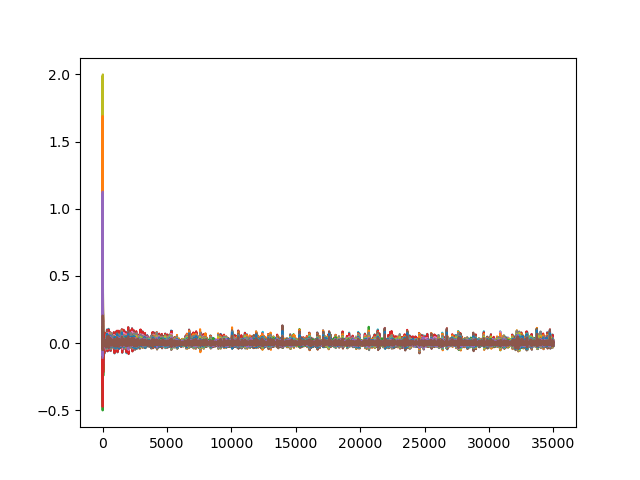

In [6]:
# plot traces
traces = sessions_stats['20211206_neurofeedback']['traces']['dff']
for i in range(56):
    plt.plot(traces[i])
plt.show()


# 